In [6]:
import tensorflow as tf
import keras 
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm
import re
from keras.preprocessing.image import img_to_array

In [10]:
# to get the files in proper order
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)

# defining the size of the image
SIZE = 256
color_img = []
path = '../input/landscape-image-colorization/landscape Images/color'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):    
    if i == '4200.jpg':  # Changed from 2200.jpg to 4000.jpg
        break
    else:    
        img = cv2.imread(path + '/'+i,1)
        # open cv reads images in BGR format so we have to convert it to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        color_img.append(img_to_array(img))

gray_img = []
path = '../input/landscape-image-colorization/landscape Images/gray'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
    if i == '4200.jpg':  # Changed from 2200.jpg to 4000.jpg
        break
    else: 
        img = cv2.imread(path + '/'+i,1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        gray_img.append(img_to_array(img))

 56%|█████▌    | 4000/7129 [00:29<00:23, 135.64it/s]


In [11]:
color_dataset=tf.data.Dataset.from_tensor_slices(np.array(color_img[:4000])).batch(64)
gray_dataset=tf.data.Dataset.from_tensor_slices(np.array(gray_img[:4000])).batch(64)

color_dataset_t=tf.data.Dataset.from_tensor_slices(np.array(color_img[4000:])).batch(8)
gray_dataset_t=tf.data.Dataset.from_tensor_slices(np.array(gray_img[4000:])).batch(8)

In [12]:
example_color = next(iter(color_dataset))
example_gray = next(iter(gray_dataset))

In [13]:
def plot_images(a = 4):
    
    for i in range(a):
        plt.figure(figsize = (10,10))
        plt.subplot(121)
        plt.title('color')
        plt.imshow(example_color[i] )

        plt.subplot(122)
        plt.title('gray')
        plt.imshow(example_gray[i])
        plt.show()

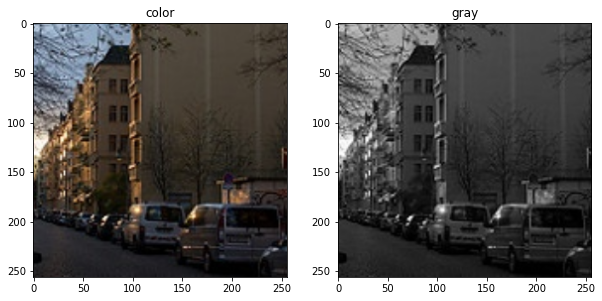

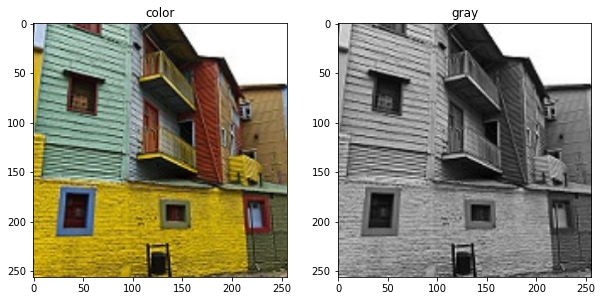

In [14]:
plot_images(2)

In [69]:
def downsample(filters, size, apply_batchnorm=True):
  
  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer='he_normal', use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

def upsample(filters, size, apply_dropout=False):
  

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer='he_normal',
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result  

In [70]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256,256,3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(3, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [71]:
generator = Generator()
generator.summary()


Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
sequential_129 (Sequential)     (None, 128, 128, 64) 3072        input_12[0][0]                   
__________________________________________________________________________________________________
sequential_130 (Sequential)     (None, 64, 64, 128)  131584      sequential_129[0][0]             
__________________________________________________________________________________________________
sequential_131 (Sequential)     (None, 32, 32, 256)  525312      sequential_130[0][0]             
____________________________________________________________________________________________

In [72]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)


In [73]:
discriminator = Discriminator()
discriminator.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
target_image (InputLayer)       [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_37 (Concatenate)    (None, 256, 256, 6)  0           input_image[0][0]                
                                                                 target_image[0][0]               
__________________________________________________________________________________________________
sequential_144 (Sequential)     (None, 128, 128, 64) 6144        concatenate_37[0][0]       

In [74]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

LAMBDA = 100

def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [75]:
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

 

In [76]:
import time
def fit(train_ds, epochs,):
  for epoch in range(epochs):
    start = time.time()

    print("Epoch: ", epoch+1)

    # Train
    for n, (input_image, target) in train_ds.enumerate():
      
      train_step(input_image, target, epoch)
    print()

  

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
  


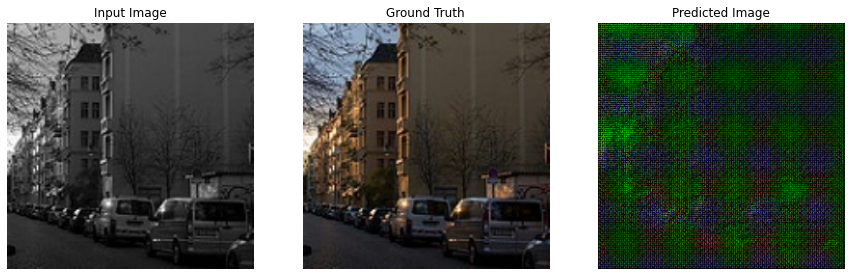

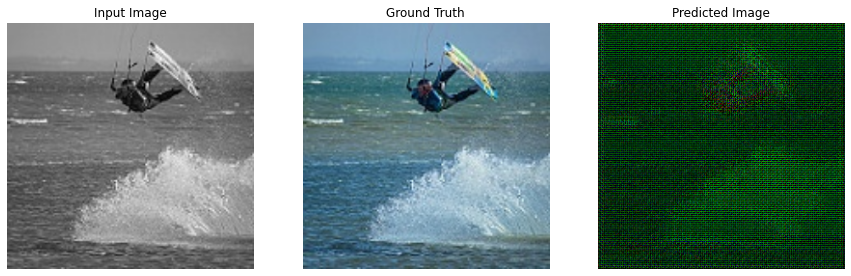

In [77]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i])
    plt.axis('off')
  plt.show()

for example_input, example_target in tf.data.Dataset.zip((gray_dataset,color_dataset)).take(2):
  generate_images(generator, example_input, example_target)


In [78]:
fit(tf.data.Dataset.zip((gray_dataset, color_dataset)),
    epochs = 30)

Epoch:  1

Time taken for epoch 1 is 87.38914513587952 sec

Epoch:  2

Time taken for epoch 2 is 87.54434871673584 sec

Epoch:  3

Time taken for epoch 3 is 87.4838478565216 sec

Epoch:  4

Time taken for epoch 4 is 87.52050709724426 sec

Epoch:  5

Time taken for epoch 5 is 87.46250605583191 sec

Epoch:  6

Time taken for epoch 6 is 87.48517155647278 sec

Epoch:  7

Time taken for epoch 7 is 87.66043162345886 sec

Epoch:  8

Time taken for epoch 8 is 87.70392394065857 sec

Epoch:  9

Time taken for epoch 9 is 87.51447486877441 sec

Epoch:  10

Time taken for epoch 10 is 87.44629096984863 sec

Epoch:  11

Time taken for epoch 11 is 87.55177283287048 sec

Epoch:  12

Time taken for epoch 12 is 87.54040765762329 sec

Epoch:  13

Time taken for epoch 13 is 87.51308012008667 sec

Epoch:  14

Time taken for epoch 14 is 87.54229760169983 sec

Epoch:  15

Time taken for epoch 15 is 87.51663255691528 sec

Epoch:  16

Time taken for epoch 16 is 87.4867193698883 sec

Epoch:  17

Time taken for e

In [79]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i])
    plt.axis('off')
  plt.show()

for example_input, example_target in tf.data.Dataset.zip((gray_dataset_t,color_dataset_t)).take(2):
  generate_images(generator, example_input, example_target)

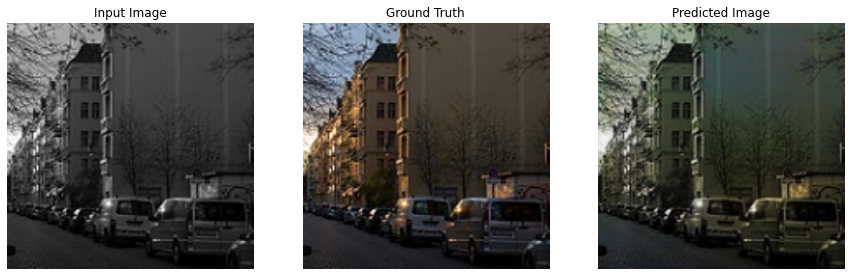

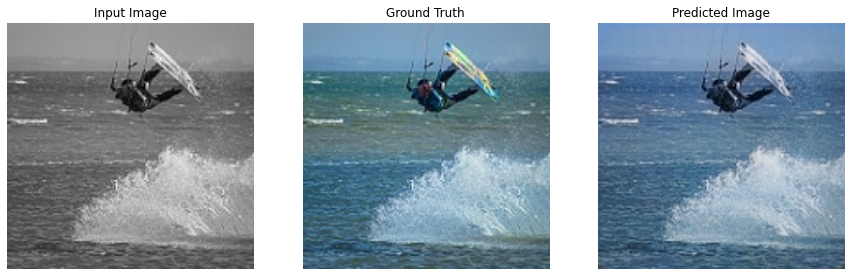

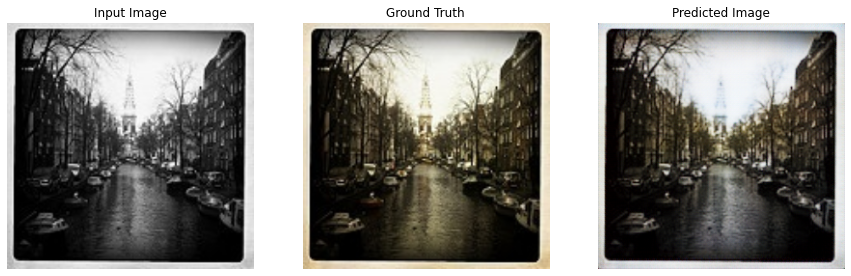

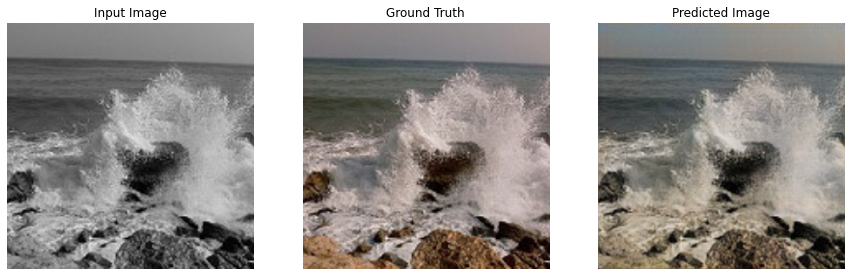

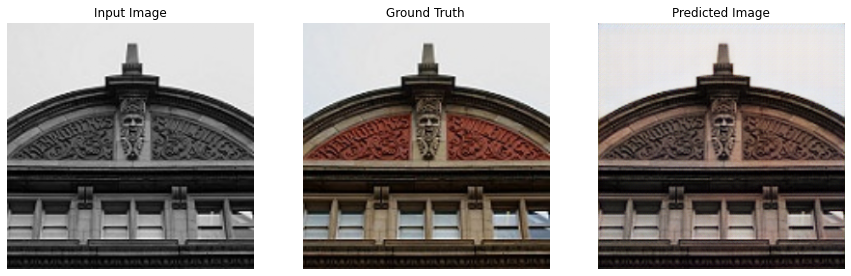

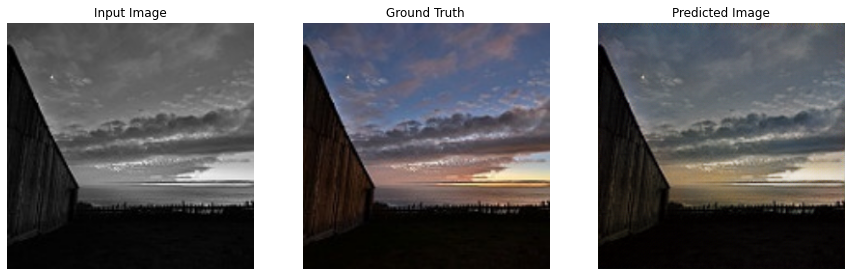

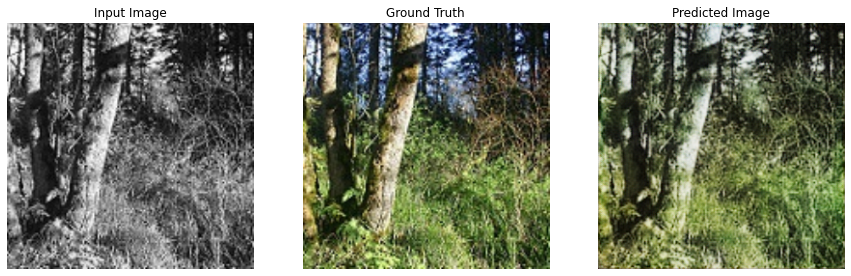

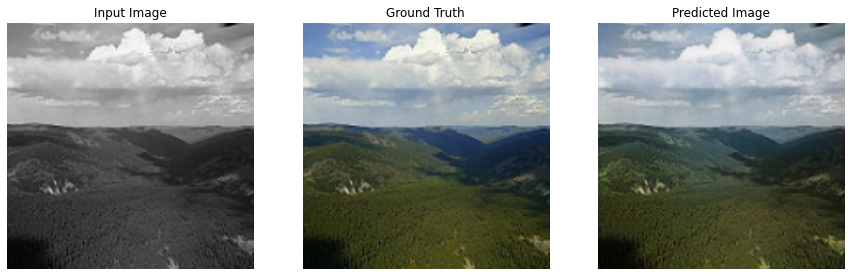

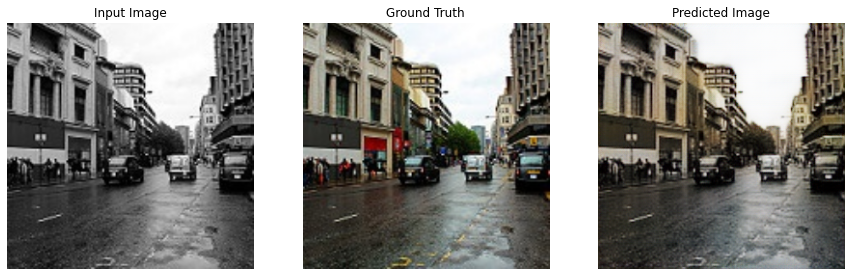

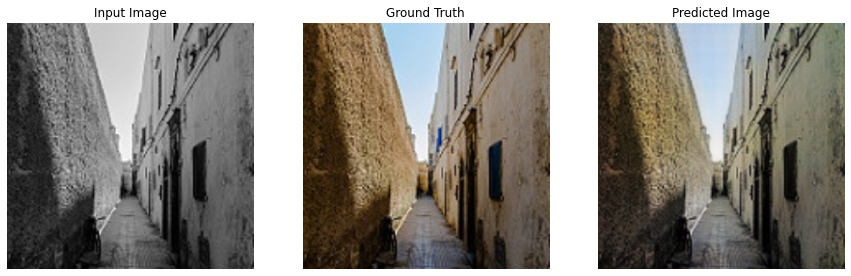

In [80]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    plt.imshow(display_list[i])
    plt.axis('off')
  plt.show()

for example_input, example_target in tf.data.Dataset.zip((gray_dataset,color_dataset)).take(10):
  generate_images(generator, example_input, example_target)


In [81]:
def save_models(generator_model, discriminator_model, save_path='saved_models'):
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    
    generator_model.save(os.path.join(save_path, 'generator.h5'))
    print(f"Generator model saved to {os.path.join(save_path, 'generator.h5')}")

    discriminator_model.save(os.path.join(save_path, 'discriminator.h5'))
    print(f"Discriminator model saved to {os.path.join(save_path, 'discriminator.h5')}")

    generator_model.save_weights(os.path.join(save_path, 'generator_weights.h5'))
    discriminator_model.save_weights(os.path.join(save_path, 'discriminator_weights.h5'))
    print("Model weights saved successfully")


save_models(generator, discriminator)

Generator model saved to saved_models/generator.h5
Discriminator model saved to saved_models/discriminator.h5
Model weights saved successfully


In [82]:

def load_models(load_path='saved_models'):

    loaded_generator = tf.keras.models.load_model(os.path.join(load_path, 'generator.h5'))
    print("Generator model loaded successfully")
    

    loaded_discriminator = tf.keras.models.load_model(os.path.join(load_path, 'discriminator.h5'))
    print("Discriminator model loaded successfully")
    
    return loaded_generator, loaded_discriminator

loaded_generator, loaded_discriminator = load_models()

Generator model loaded successfully
Discriminator model loaded successfully


In [101]:
def increase_saturation(image, saturation_factor=1.5):


    if isinstance(image, tf.Tensor):
        image = image.numpy()
    

    if image.max() > 1.0:
        image = image / 255.0
    

    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    

    hsv_image[:, :, 1] = np.clip(hsv_image[:, :, 1] * saturation_factor, 0, 1)
    

    saturated_image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)
    
    return saturated_image

In [106]:
def colorize_and_compare(img_file, saturation_factor=2.0, save_images=True):

    gray_img_path = f'/kaggle/input/landscape-image-colorization/landscape Images/gray/{img_file}'
    true_color_img_path = f'/kaggle/input/landscape-image-colorization/landscape Images/color/{img_file}'
    
    gray_img = cv2.imread(gray_img_path, 1)
    if gray_img is None:
        print(f"Error: Could not load grayscale image at {gray_img_path}")
        return None
        
    gray_img = cv2.cvtColor(gray_img, cv2.COLOR_BGR2RGB)
    gray_img_resized = cv2.resize(gray_img, (SIZE, SIZE))
    gray_img_normalized = gray_img_resized.astype('float32') / 255.0
    
    true_color_img = cv2.imread(true_color_img_path, 1)
    if true_color_img is None:
        print(f"Error: Could not load color image at {true_color_img_path}")
        return None
        
    true_color_img = cv2.cvtColor(true_color_img, cv2.COLOR_BGR2RGB)
    true_color_img_resized = cv2.resize(true_color_img, (SIZE, SIZE))
    true_color_img_normalized = true_color_img_resized.astype('float32') / 255.0
    
    test_img_tensor = tf.convert_to_tensor(gray_img_normalized)
    test_img_tensor = tf.expand_dims(test_img_tensor, 0)  
    

    generated_image = loaded_generator(test_img_tensor, training=False)
    generated_image_np = tf.squeeze(generated_image).numpy()
    
    saturated_image = increase_saturation(generated_image_np, saturation_factor=saturation_factor)
    
    plt.figure(figsize=(20, 5))

    plt.subplot(1, 4, 1)
    plt.title('Grayscale Image')
    plt.imshow(gray_img_resized)
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.title('Original Color Image')
    plt.imshow(true_color_img_resized)
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.title('Model Prediction')
    plt.imshow(generated_image_np)
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.title('Enhanced Saturation')
    plt.imshow(saturated_image)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

    if save_images:
        cv2.imwrite(f'original_gray_{img_file}', cv2.cvtColor(gray_img_resized, cv2.COLOR_RGB2BGR) * 255)
        cv2.imwrite(f'true_color_{img_file}', cv2.cvtColor(true_color_img_resized, cv2.COLOR_RGB2BGR) * 255)
        cv2.imwrite(f'model_prediction_{img_file}', cv2.cvtColor(generated_image_np, cv2.COLOR_RGB2BGR) * 255)
        cv2.imwrite(f'saturated_prediction_{img_file}', cv2.cvtColor(saturated_image, cv2.COLOR_RGB2BGR) * 255)
        print(f"All images for {img_file} have been saved")
    
    # # Return the processed images dictionary
    # return {
    #     'grayscale': gray_img_resized,
    #     'true_color': true_color_img_resized,
    #     'prediction': generated_image_np,
    #     'enhanced': saturated_image
    # }



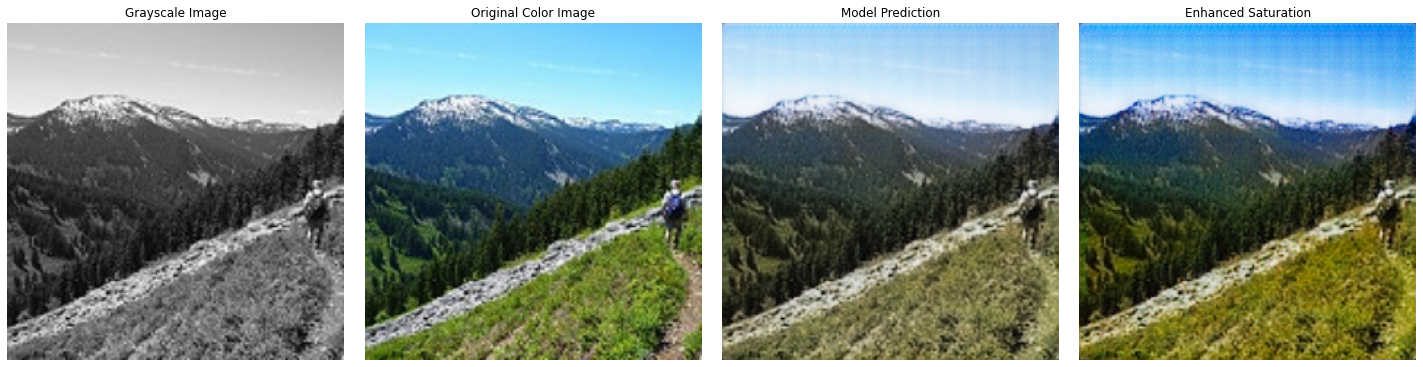

All images for 6028.jpg have been saved


In [107]:
colorize_and_compare('6028.jpg')

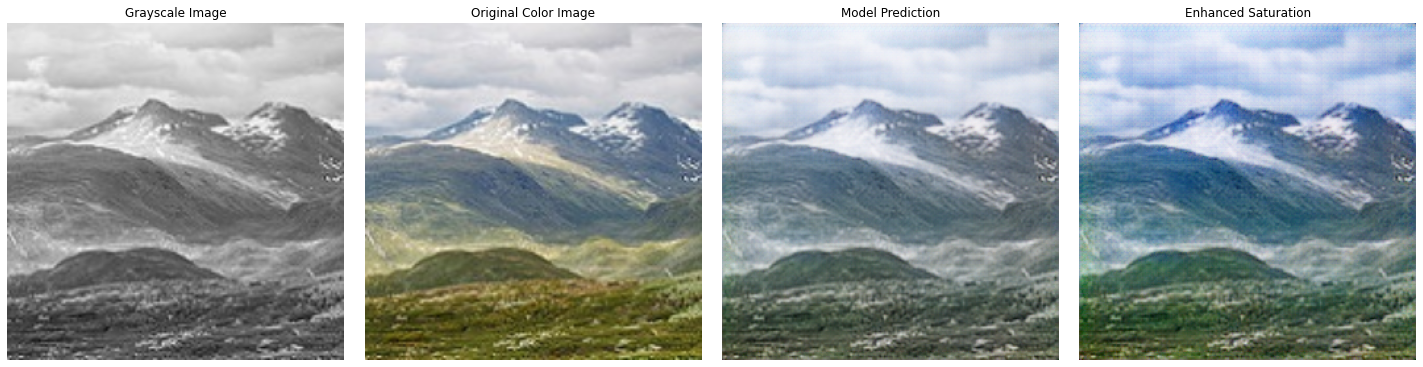

All images for 6550.jpg have been saved


In [111]:
colorize_and_compare('6550.jpg')

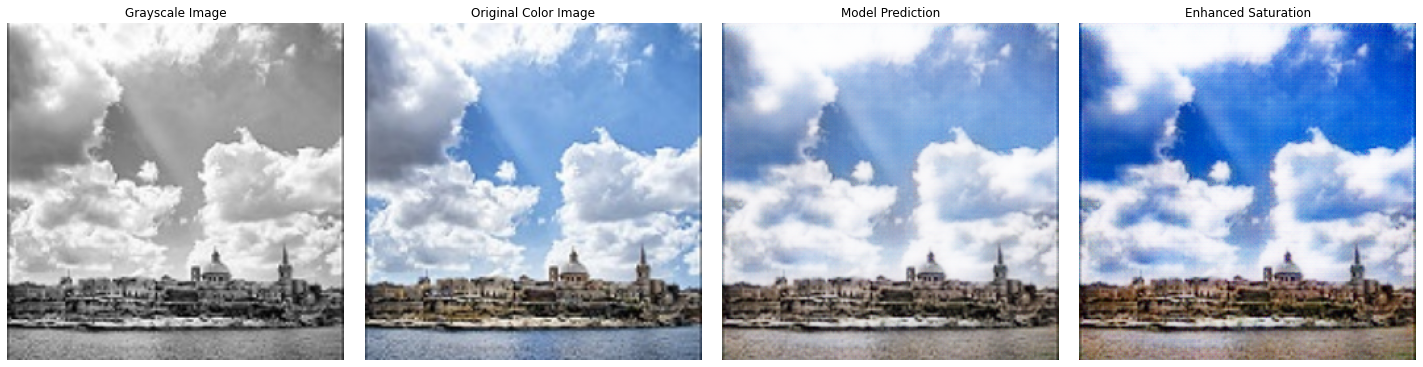

All images for 650.jpg have been saved


In [113]:
colorize_and_compare('650.jpg')

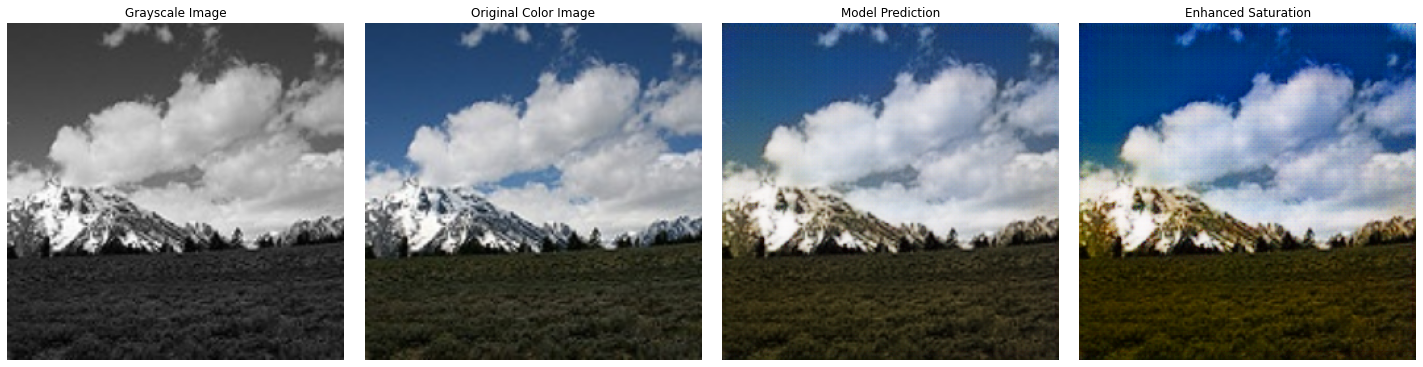

All images for 6120.jpg have been saved


In [122]:
colorize_and_compare('6120.jpg')